# Applying refutation tests to the Lalonde and IHDP datasets

## Import the Dependencies

In [1]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Loading the Dataset

## Infant Health and Development Program Dataset (IHDP)

The measurements used are on the child—birth weight, head circumference, weeks bornpreterm, birth order, ﬁrst born, neonatal health index (see Scott and Bauer 1989), sex, twinstatus—as well as behaviors engaged in during the pregnancy—smoked cigarettes, drankalcohol, took drugs—and measurements on the mother at the time she gave birth—age,marital status, educational attainment (did not graduate from high school, graduated fromhigh school, attended some college but did not graduate, graduated from college), whethershe worked during pregnancy, whether she received prenatal care—and the site (8 total) inwhich the family resided at the start of the intervention. There are 6 continuous covariatesand 19 binary covariates.

### Reference
Hill, J. L. (2011). Bayesian nonparametric modeling for causal inference. Journal of Computational and Graphical Statistics, 20(1), 217-240. https://doi.org/10.1198/jcgs.2010.08162

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data = data.astype({"treatment":'bool'}, copy=False)
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


## Lalonde Dataset

A data frame with 445 observations on the following 12 variables.

- age:
age in years.
- educ:
years of schooling.
- black:
indicator variable for blacks.
- hisp:
indicator variable for Hispanics.
- married:
indicator variable for martial status.
- nodegr:
indicator variable for high school diploma.
- re74:
real earnings in 1974.
- re75:
real earnings in 1975.
- re78:
real earnings in 1978.
- u74:
indicator variable for earnings in 1974 being zero.
- u75:
indicator variable for earnings in 1975 being zero.
- treat:
an indicator variable for treatment status.

### References
Dehejia, Rajeev and Sadek Wahba. 1999.``Causal Effects in Non-Experimental Studies: Re-Evaluating the Evaluation of Training Programs.'' Journal of the American Statistical Association 94 (448): 1053-1062.

LaLonde, Robert. 1986. ``Evaluating the Econometric Evaluations of Training Programs.'' American Economic Review 76:604-620.

In [3]:
from rpy2.robjects import r as R

from os.path import expanduser
home = expanduser("~")

%reload_ext rpy2.ipython

# %R install.packages("Matching")
%R library(Matching)

R[write to console]: Loading required package: MASS



R[write to console]: ## 
##  Matching (Version 4.10-2, Build Date: 2022-04-13)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




'Matching','MASS','tools',...,'datasets','methods','base'


In [4]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)
lalonde.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
1,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,True
2,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,True
3,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,True
4,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,True
5,33,8,1,0,0,1,0.0,0.0,289.79,1,1,True


## Step 1: Building the model

## IHDP

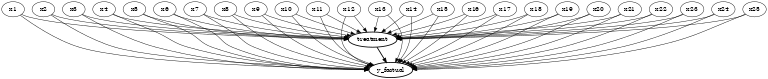

In [5]:
# Create a causal model from the data and given common causes

common_causes = []

for i in range(1, 26):
    common_causes += ["x"+str(i)]

ihdp_model = CausalModel(
                data=data,
                treatment='treatment',
                outcome='y_factual',
                common_causes=common_causes
            )
ihdp_model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Lalonde

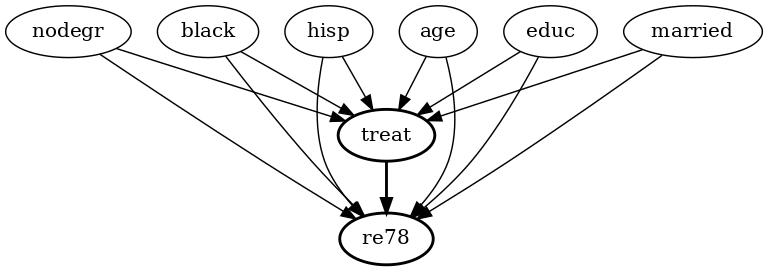

In [6]:
lalonde_model = CausalModel(
                data=lalonde,
                treatment='treat',
                outcome='re78',
                common_causes='nodegr+black+hisp+age+educ+married'.split('+')
            )
lalonde_model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step 2: Identification

## IHDP

In [7]:
#Identify the causal effect for the ihdp dataset
ihdp_identified_estimand = ihdp_model.identify_effect(proceed_when_unidentifiable=True)
print(ihdp_identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[y_factual|x11,x18,x8,x21,x12,x10,x9,x14,x23,x7,x19,x3,x16,x15,x
d[treatment]                                                                  

                                       
24,x20,x22,x5,x1,x4,x13,x17,x2,x6,x25])
                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x11,x18,x8,x21,x12,x10,x9,x14,x23,x7,x19,x3,x16,x15,x24,x20,x22,x5,x1,x4,x13,x17,x2,x6,x25,U) = P(y_factual|treatment,x11,x18,x8,x21,x12,x10,x9,x14,x23,x7,x19,x3,x16,x15,x24,x20,x22,x5,x1,x4,x13,x17,x2,x6,x25)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Lalonde

In [8]:
#Identify the causal effect for the lalonde dataset
lalonde_identified_estimand = lalonde_model.identify_effect(proceed_when_unidentifiable=True)
print(lalonde_identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                
────────(E[re78|hisp,nodegr,black,age,married,educ])
d[treat]                                            
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,hisp,nodegr,black,age,married,educ,U) = P(re78|treat,hisp,nodegr,black,age,married,educ)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Step 3: Estimation (using propensity score weighting)

## IHDP

In [9]:
ihdp_estimate = ihdp_model.estimate_effect(
                    ihdp_identified_estimand,
                    method_name="backdoor.propensity_score_weighting"
                )

print("The Causal Estimate is " + str(ihdp_estimate.value))

The Causal Estimate is 4.028748218390403


## Lalonde

In [10]:
lalonde_estimate = lalonde_model.estimate_effect(
                        lalonde_identified_estimand,
                        method_name="backdoor.propensity_score_weighting"
                    )

print("The Causal Estimate is " + str(lalonde_estimate.value))

The Causal Estimate is 1639.8548218632895


## Step 4:  Refutation

## IHDP

### Add Random Common Cause

In [11]:
ihdp_refute_random_common_cause = ihdp_model.refute_estimate(
                                        ihdp_identified_estimand,
                                        ihdp_estimate,
                                        method_name="random_common_cause"
                                    )

print(ihdp_refute_random_common_cause)

Refute: Add a random common cause
Estimated effect:4.028748218390403
New effect:4.029294172379883
p value:0.86



### Replace Treatment with Placebo

In [12]:
ihdp_refute_placebo_treatment = ihdp_model.refute_estimate(
                                    ihdp_identified_estimand,
                                    ihdp_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )

print(ihdp_refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:4.028748218390403
New effect:-0.014852759358386404
p value:0.96



### Remove Random Subset of Data

In [13]:
ihdp_refute_random_subset = ihdp_model.refute_estimate(
                                    ihdp_identified_estimand,
                                    ihdp_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8
                            )
print(ihdp_refute_random_subset)

Refute: Use a subset of data
Estimated effect:4.028748218390403
New effect:4.013387505429109
p value:0.78



## Lalonde

### Add Random Common Cause

In [14]:
lalonde_refute_random_common_cause = lalonde_model.refute_estimate(
                                            lalonde_identified_estimand,
                                            lalonde_estimate,
                                            method_name="random_common_cause"
                                        )

print(lalonde_refute_random_common_cause)

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Refute: Add a random common cause
Estimated effect:1639.8548218632895
New effect:1635.1636223539201
p value:0.8600000000000001



/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

### Replace Treatment with Placebo

In [15]:
lalonde_refute_placebo_treatment = lalonde_model.refute_estimate(
                                        lalonde_identified_estimand,
                                        lalonde_estimate,
                                        method_name="placebo_treatment_refuter",
                                        placebo_type="permute"
                                    )

print(lalonde_refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:1639.8548218632895
New effect:-37.72405931577553
p value:0.8400000000000001



### Remove Random Subset of Data

In [16]:
lalonde_refute_random_subset = lalonde_model.refute_estimate(
                                    lalonde_identified_estimand,
                                    lalonde_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.9
                                )

print(lalonde_refute_random_subset)

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Refute: Use a subset of data
Estimated effect:1639.8548218632895
New effect:1622.8754074274073
p value:0.96

